In [1]:
from math import *
from scipy.special.orthogonal import hermite
from scipy.special import eval_hermite
from scipy import fftpack

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.image import imsave
# from scipy.special import airy
# from scipy.special import jn

# to generate random state vectors
from scipy.stats import unitary_group
from scipy.ndimage.interpolation import rotate
from astropy.convolution import AiryDisk2DKernel
from astropy.modeling.functional_models import AiryDisk2D
from scipy.stats import norm
from skimage import color, data, restoration
from datetime import datetime

import torch
import os
from PIL import Image, ImageOps

In [2]:
################################# Experimental parameters #################################
wavelength = 785e-9
DMD_pixel = 7.56 * 1e-6
DMD_logic_pixel = 10*DMD_pixel

# in our previous experiment: NA = 1.76*1e-4
# in simulation to read UNIVERSITY: NA = 8e-3
NA = 0.667e-3 #8e-3

DMD_basis = 21 #21 # we assume a basis of DMD_basis, each 10 pixels
HG_basis = 15+1#10+1 # mode 10 included | HG projection basis eg. 15 -> (15,15)

In [3]:
unit = wavelength / (2*NA)
rayleigh_distance =  1.22 * unit

simulation_windows = DMD_logic_pixel*3*DMD_basis - 0.57e-4 # = 3*21 #9*7 logical pixels

x = np.linspace(-simulation_windows/2, simulation_windows/2, num=250, endpoint=True) # np.linspace(-12,12,961) * 1e-3 
y = np.linspace(-simulation_windows/2, simulation_windows/2, num=250, endpoint=True)
X, Y = np.meshgrid(x, y, sparse=False)

simulation_unit = x[1] - x[0]
print('simulation_unit: {}'.format(simulation_unit)) 

# up_scale used to convert img 21x21 to simulation scaling
up_scale = int(np.round(DMD_logic_pixel*1.0/simulation_unit))
print('up scale for img 21x21: {}'.format(up_scale)) 
print('DMD_logic_pixel / simulation_unit: {}'.format(DMD_logic_pixel/simulation_unit))

sigma = 0.21 * wavelength / NA 

simulation_unit: 1.889879518072275e-05
up scale for img 21x21: 4
DMD_logic_pixel / simulation_unit: 4.000255004462608


In [4]:
################################## cache some stuff to speed up calculation #################################
# hermite polynomials
hermite_pol_coeff_inv = []

for i in range(HG_basis):
    hermite_pol_coeff_inv.append(hermite(i).coef[::-1])
    
# E_HG terms
E_HG_constant_term = np.zeros((HG_basis, HG_basis, X.shape[0], Y.shape[0]))

for i in range(HG_basis):
        for j in range(HG_basis):
            x_factor = eval_hermite(i, X/(2*sigma)) / (2**(i+1) * factorial(i) * (np.sqrt(np.pi) * sigma))
            y_factor = eval_hermite(j, Y/(2*sigma)) / (2**(j+1) * factorial(j) * (np.sqrt(np.pi) * sigma))
            
            E_HG_constant_term[i,j, :, :] = x_factor * y_factor * np.exp(-(X/(2*np.sqrt(2)*sigma))**2) * np.exp(-(Y/(2*np.sqrt(2)*sigma))**2)
###############################################################################################################

# PSF functions

In [35]:
def gaussian_psf(size,sigma,centre=125):
    """
    Calculates the gaussian point spread function (PSF) for a given size and width
    
    Parameters
    ---------------
    size : float
    
    Numpy Array size for the gaussian PSF
    
    sigma : float
    
    width of the gaussian PSF
    
    centre: int ; optional
    
    centre position in (250,250) 
    
    Returns
    -----------
    PSF : ndarray
    
    The Gaussian PSF with shape: (size, size) and width: sigma. 
    
    """
    x = np.linspace(-simulation_windows/2, simulation_windows/2, num=250, endpoint=True) # np.linspace(-12,12,961) * 1e-3 
    y = np.linspace(-simulation_windows/2, simulation_windows/2, num=250, endpoint=True)
    X, Y = np.meshgrid(x, y, sparse=False)
    PSF = (1/ ( ((2*np.pi)**(1/4)) * np.sqrt(sigma) )) * np.exp(-(X/(2*sigma))**2) * np.exp(-(Y/(2*sigma))**2) #  / (4 * sigma**2)) * np.exp(-Y**2 / (4 * sigma**2))
    PSF=PSF[centre-int(size/2):centre+int(size/2),centre-int(size/2):centre+int(size/2)]/ np.sqrt(np.sum(np.abs(PSF)**2) +1e-10)
    return PSF

def airy_psf(size,ai_radius):
    """
    Calculates the airy point spread function (PSF) for a given size and width
    
    Special Requirements: from astropy.modeling.functional_models import AiryDisk2D
    
    Parameters
    ---------------
    size : float
    
    Numpy Array size for the Airy PSF
    
    ai_radius : float
    
    radius of the airy disk , the radius of the first zero of Airy PSF
    
    Returns
    -----------
    ai : ndarray
    
    The Airy PSF with shape: (size, size) and radius of the first zero: ai_radius. 
    
    """
    sx, sy = size, size
    X, Y = np.ogrid[0:sx, 0:sy]
    
    # airy=AiryDisk2DKernel(12.5)
    airy=AiryDisk2D(1,0,0,20)
    ai=airy.evaluate(X,Y,1,sx/2,sy/2,ai_radius)

    try: #necessary if DMD image is 8bit format
        airy = np.asarray(ai).astype(float)[:,:,0]
    except IndexError:
        airy = np.asarray(ai).astype(float)
    
    return ai


# General Functions

In [8]:
def propagate(source, PSF):
    """
    Calculates the field distribution in image plane for a given field distribution at the source and Point Spread Function
    """
#     image = signal.fftconvolve(source, PSF, mode='same')
    image = signal.convolve(source, PSF, mode='same')
    image_norm = image / np.sqrt(np.sum(np.abs(image)**2) +1e-10) # normalize image
    return image_norm

def HG_mode2d(X, Y, m, n, w):
    """
    Returns a 2D normalized HG mode of beam waist w, (m, n) order, in (x,y) plane
    """
    ux = X / (w * np.sqrt(2))
    uy = Y / (w * np.sqrt(2))
    numerator =  eval_hermite(m, ux) * np.exp(-X**2 / (4*(w**2)) ) * eval_hermite(n, uy) * np.exp(-Y**2 / (4*(w**2)) )
    denominator = (2*np.pi)**(1/4) * np.sqrt( (2**m) * factorial(m) * w ) * (2*np.pi)**(1/4) * np.sqrt( (2**n) * factorial(n) * w )
    mode = numerator / denominator 
    return mode / np.sqrt( np.sum (np.abs(mode)**2) )

def decomposition_basis2d(dim):
    """
    Returns a 2D basis of (dim) HG modes.
    E.g. a = decomposition_basis2d(2) # HG basis: 00, 01, 10, 11
    """
    base_state = np.zeros((dim, dim, X.shape[0], X.shape[1]), dtype='float')
    for m in range(dim):
        for n in range(dim):
            base_state[m, n, :, :] = HG_mode2d(X, Y, m, n, sigma)
    return base_state

# HG basis    
basis = decomposition_basis2d(HG_basis)

def photocurrents2d(image, base_state):
    """
    Returns the photocurrents of heterodyne detections for a given HG basis
    
    Args:
        image -- matrix of complex elements
        base_state -- tensor of dimension [m,n,len(x),len(y)]
        
    Returns:
        J_n -- matrix [m,n]
    """
    dim = np.shape(base_state)[0]
    J_n = np.zeros((dim, dim), dtype='float')
    for i in range(dim):
        for j in range(dim):
            J_n[i,j] = np.sum( image[:,:] * np.conj(base_state[i,j,:,:]) )
    return J_n

def beta_coef2d_fast(J_n, base_state):
    """
    Returns the beta coeff of the source electric field from the measured photocurrents.
    Used cached results to speep up computation time.
 
    Args:
        J_n -- matrix [m,n]
        base_state -- tensor of dimension [m,n,len(x),len(y)]
        
    Returns:
        beta -- matrix [m,n]

    """
    dim = len(base_state)
    beta = np.zeros((dim, dim), dtype='float')
    for i in range(dim):
        for j in range(dim):
            for m in range(i+1):
                for n in range(j+1):
                    beta[i, j] += hermite_pol_coeff_inv[i][m] * hermite_pol_coeff_inv[j][n] * sqrt(factorial(m)) * sqrt(factorial(n)) * J_n[m,n]
    return beta

def beta_coef2d(J_n, base_state):
    """
    Returns the beta coeff of the source electric field from the measured photocurrents
 
    Args:
        J_n -- matrix [m,n]
        base_state -- tensor of dimension [m,n,len(x),len(y)]
        
    Returns:
        beta -- matrix [m,n]

    """
    dim = len(base_state)
    beta = np.zeros((dim, dim), dtype='float')
    for i in range(dim):
        for j in range(dim):
            for m in range(i+1):
                for n in range(j+1):
                    beta[i, j] += (hermite(i).coef[::-1])[m] * (hermite(j).coef[::-1])[n] * sqrt(factorial(m)) * sqrt(factorial(n)) * J_n[m,n]
    return beta

def HG_microscopy2d(image, basis=basis, dim=HG_basis):
    """
    Calculates 2D reconstructed electric field from HG microscopy.

    Args:
        image -- matrix [m,n], electric field (complex array) at the image plane, 
        dim -- integer, dimension of the HG projection basis 

    Returns:
        E_HG -- matrix [x,y], reconstructed source electric field
        beta -- matrix [m,n], reconstructed source electric field HG beta coefficients
        J_n -- matrix [m,n], heterodyne photocurrents
    """     
    J_n = photocurrents2d(image, basis)
    beta = beta_coef2d_fast(J_n, basis)
    E_HG = 0
    for i in range(dim):
        for j in range(dim):
            #x_factor = eval_hermite(i, X/(2*sigma)) / (2**(i+1) * factorial(i) * (np.sqrt(np.pi) * sigma))
            #y_factor = eval_hermite(j, Y/(2*sigma)) / (2**(j+1) * factorial(j) * (np.sqrt(np.pi) * sigma))
                            
            E_HG += beta[i,j] * E_HG_constant_term[i,j, :, :] #* x_factor * y_factor * np.exp(-(X/(2*np.sqrt(2)*sigma))**2) * np.exp(-(Y/(2*np.sqrt(2)*sigma))**2) 
            
    return E_HG, beta, J_n 


#def get_PSF(NA):
#    """
#    Calculates 2D PSF given a numerical aperture. 
#    Args:
#        NA -- integer, note that in our previous experiment: NA = 1.76*1e-4
#    Returns:
#        PSF -- matrix [x,y] of real value, 2D Point Spread Function under Guassian approximation
#    """
#    sigma = 0.21 * wavelength / NA 
#    PSF = (1/ ( ((2*np.pi)**(1/4)) * np.sqrt(sigma) )) * np.exp(-X**2 / (4 * sigma**2)) * np.exp(-Y**2 / (4 * sigma**2))
#    return PSF

def interp_near_pixels(image, interp_factor=4):
    """ Increse size of an image by taking neighbour pixel value.
    Used to increase size of (X,Y), so that PSF and HG modes are smoother."""
    img_interp = np.zeros((image.shape[0]*interp_factor,image.shape[1]*interp_factor))
    for i in range(np.shape(image)[0]):
        for j in range(np.shape(image)[1]):
            img_interp[i*interp_factor:(i+1)*interp_factor,j*interp_factor:(j+1)*interp_factor] = image[i,j]
    return img_interp

def interp_near_pixels_xy(image, interp_factor_x, interp_factor_y):
    """ Increse size of an image differently along x and y by taking neighbour pixel value.
    Used to increase size of (X,Y), so that PSF and HG modes are smoother."""
    img_interp = np.zeros((image.shape[0]*interp_factor_y,image.shape[1]*interp_factor_x))
    for i in range(np.shape(image)[0]):
        for j in range(np.shape(image)[1]):
            img_interp[i*interp_factor_y:(i+1)*interp_factor_y,j*interp_factor_x:(j+1)*interp_factor_x] = image[i,j]
    return img_interp



def recompose_img(sources):
    """ Recompose an images from a set of images, like from an ordered puzzle.
    
    Args:
        sources -- tensor (num_img_along_x, num_img_along_y, size_img_x, size_img, y)
    
    Outputs:
        reconstructed_source -- matrix (num_img_along_x*size_img_x, num_img_along_y*size_img, y)
    """
    vertical_strips = np.zeros(( sources.shape[1], sources.shape[2]*sources.shape[0], sources.shape[3]  ))
    for j in range(sources.shape[1]):
        vertical_strips[j, :, :] = np.concatenate(sources[:,j,:,:], axis=0)
    return np.concatenate(vertical_strips[:,:], axis=1)

def recompose_img_with_padding(sources, padding_margin):
    """ Recompose an images from a set of images, removing padding space.
    
    Args:
        sources -- tensor (num_img_along_x, num_img_along_y, size_img_x, size_img, y)
    
    Outputs:
        reconstructed_source -- matrix (num_img_along_x*size_img_x, num_img_along_y*size_img, y)
    """ 
    half_pad = int(padding_margin/2)
    
    x_imgs, y_imgs = sources.shape[0], sources.shape[1]
    x_square, y_square = sources.shape[2], sources.shape[3]
    
    x_square_no_pad = x_square-padding_margin
    y_square_no_pad = y_square-padding_margin


    reconstructed_image = np.zeros(( x_square_no_pad*x_imgs, y_square_no_pad*y_imgs ))
    print(reconstructed_image.shape)
    for i in range(x_imgs):
        for j in range(y_imgs):
            reconstructed_image[x_square_no_pad*i:x_square_no_pad*(i+1), y_square_no_pad*j:y_square_no_pad*(j+1)] = \
                remove_padding(sources[i,j, :,:], padding_margin)
    return reconstructed_image      

def remove_padding(image, padding):
    """ Return img without padding """
    half_pad = int(padding/2)
    x_size, y_size = image.shape[0], image.shape[1]
    return image[half_pad:x_size-half_pad, half_pad:y_size-half_pad]

def concate_pad_images(images, padding):
    """ Return the complete image from its pieces which have padding. 
    
    Args:
        images -- tensor (num_img_along_x, num_img_along_y, size_img_x, size_img, y)
        
        note: size_img_x = x_square_no_pad+padding
    
    Outputs:
        img_tot -- matrix (num_img_x*x_square_no_pad+padding, num_img_y*y_square_no_pad+padding, y)
    """
    num_img_x, num_img_y = images.shape[0], images.shape[1]
    x_square, y_square = images.shape[2], images.shape[3]
    x_square_no_pad, y_square_no_pad = x_square-padding, y_square-padding

    img_tot = np.zeros(( num_img_x*x_square_no_pad+padding, num_img_y*y_square_no_pad+padding ))

    count=0
    for i in range(num_img_y):
        for j in range(num_img_x):
            #print(j,i)
            img_tot[j*y_square_no_pad:j*y_square_no_pad+y_square, i*x_square_no_pad:i*x_square_no_pad+x_square] += \
                images[j,i,:,:]
            count+=1
    #print('images concatenated removing padding: '+str(count))
    return img_tot

def img21x21_to_sim_size(an_img_21x21, x, up_scale):
    """ Interpolate and pad an image 21x21 to make it compatible with simulation (X,Y) sizes. """
    interp_img = interp_near_pixels(an_img_21x21, up_scale)
    
    padding = x.shape[0]-interp_img.shape[0]
    source_pad = np.pad(interp_img, (int(padding/2), int(padding/2)) , mode='constant', constant_values=0)
    return source_pad, padding


# Convolution and Deconvolution Functions

In [12]:
def convolve(star, psf):
    """
    2D fft  convolution, Takes 2 arguments, convolves them and returns convolution
    """
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft*psf_fft)))

def deconvolve(star, psf):
    """
    2D fft  deconvolution
    
    Parameters
    -----------
    star: convolution result of 2 objects
    psf: one of the reference objects
    
    Returns:
    Another reference object
    """
    star_fft = fftpack.fftshift(fftpack.fftn(star))
    psf_fft = fftpack.fftshift(fftpack.fftn(psf))
    return fftpack.fftshift(fftpack.ifftn(fftpack.ifftshift(star_fft/psf_fft)))

# Richardson_Lucy Deconvolution

### deconv_rl(image,initial_estimate, psf, iterations=50, clip=False, filter_epsilon=None)

general algorithm to perform richardson lucy deconvolution
    Parameters
    ----------
    image : ndarray
       Input degraded image (can be N dimensional).
    initial_estimate: ndarray
        Initial estimate for object to be estimated. Same shape as image.
    psf : ndarray
       The point spread function.
    iterations : int, optional
       Number of iterations. This parameter plays the role of
       regularisation.
    clip : boolean, optional
       False by default. If true, pixel value of the result above 1 or
       under -1 are thresholded.
    filter_epsilon: float, optional
       Value below which intermediate results become 0 to avoid division
       by small numbers.
    Returns
    -------
    im_deconv : ndarray
       The deconvolved image.
       
### ref_deconv_rl(image,initial_estimate, ref_obj, psf, iterations=50, clip=False, filter_epsilon=None)

test algorithm to perform richardson lucy deconvolution, it allows to cross reference against the original reference object and calculates MSE loss as a metric of performance.
    Parameters
    ----------
    image : ndarray
       Input degraded image (can be N dimensional).
    initial_estimate : ndarray
       Initial estimate for object to be estimated. Same shape as image.
    ref_obj : ndarray
       Reference object to calculate Mean Squared Error Loss against result of deconvolution. Same shape as image.
    psf : ndarray
       The point spread function.
    iterations : int, optional
       Number of iterations. This parameter plays the role of
       regularisation.
    clip : boolean, optional
       False by default. If true, pixel value of the result above 1 or
       under -1 are thresholded.
    filter_epsilon: float, optional
       Value below which intermediate results become 0 to avoid division
       by small numbers.
    Returns
    -------
    im_deconv : ndarray
       The deconvolved image.
       
   ### References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution

In [22]:
def deconv_rl(image,initial_estimate, psf, iterations=50, clip=False, filter_epsilon=None):

    complex_type = np.promote_types(image.dtype, np.complex128)
    image = image.astype(complex_type, copy=False)
    psf = psf.astype(complex_type, copy=False)
    initial_estimate=initial_estimate.astype(complex_type, copy=False)
    im_deconv = initial_estimate.copy()
    psf_mirror = np.flip(psf)
    for _ in range(iterations):
        conv = signal.convolve(im_deconv, psf,'same')
        if filter_epsilon:
            relative_blur = np.where(conv < filter_epsilon, 0, image / conv)
        else:
            relative_blur = image / conv
        im_deconv *= signal.convolve(relative_blur, psf_mirror,'same')
        
    if clip:
        im_deconv[im_deconv > 1] = 1
        im_deconv[im_deconv < -1] = -1
    return im_deconv

def ref_deconv_rl(image,initial_estimate, ref_obj, psf, iterations=50, clip=False, filter_epsilon=None):

    complex_type = np.promote_types(image.dtype, np.complex128)
    image = image.astype(complex_type, copy=False)
    psf = psf.astype(complex_type, copy=False)
    initial_estimate=initial_estimate.astype(complex_type, copy=False)
    mse_loss=np.zeros(iterations)
    mse_loss=mse_loss.astype(complex_type, copy=False)
    im_deconv = initial_estimate.copy()
    psf_mirror = np.flip(psf)
    
    for _ in range(iterations):
        conv = signal.convolve(im_deconv, psf,'same')
        if filter_epsilon:
            relative_blur = np.where(conv < filter_epsilon, 0, image / conv)
        else:
            relative_blur = image / conv
        im_deconv *= signal.convolve(relative_blur, psf_mirror,'same')
        temp=im_deconv.copy()
        temp=temp/np.max(temp)
        temp[temp>0.075]=1
        temp[temp==0.075]=1
        temp[temp<0.075]=0
        mse_loss[_]=np.sum((temp-ref_obj)**2)
        
    if clip:
        im_deconv[im_deconv > 1] = 1
        im_deconv[im_deconv < -1] = -1
    return im_deconv,mse_loss,temp

# Settings for Experimental Deconvolution

In [38]:
"""
File sequence to import
"""
seq=[]
# for i in range(30):
#     seq.extend(['logo_'+str(i)])
# for i in range(30):
#     seq.extend([str(i)])
# for i in range(120):
#     seq.extend([str(i)])
for i in range(96):
    seq.extend([str(i)])
# for i in range(56):
#     seq.extend([str(i)])

In [39]:
"""
Folder paths
"""

## folder for borders
load_folder=r'D:\Projects Data\2D_HGM_data\direct_imaging\for_mapping\grid_without_iris/'

## folder for camera direct images with the iris
camera_folder=r'D:\Projects Data\2D_HGM_data\direct_imaging\alphabet/'

## Experimental PSF folder
PSF_folder=r'D:\Projects Data\2D_HGM_data\direct_imaging/'

##saving torch tensors
torch_folder=r'D:\Projects Data\2D_HGM_data\direct_imaging\tensors/'

## saving result from deconvolution
save_folder=r'C:\Users\papat\Documents\Direct_Imaging\convolution/'

In [40]:
"""
Initial declaration

img_size: array size of individual frames
logo: total frames and shape of total frames

"""

img_size = 120 #360#140 #120 

# logo = np.zeros((12, 10, img_size, img_size))
logo = np.zeros((8, 12, img_size, img_size))
# logo = np.zeros((3, 10, img_size, img_size))
# logo = np.zeros((8, 7, img_size, img_size))

##coordinates to look at in image frame using borders
y_min, y_max = 600,600+img_size #585,600 #480,495 #600,615
x_min, x_max = 615,615+img_size

(array([680], dtype=int64), array([659], dtype=int64))


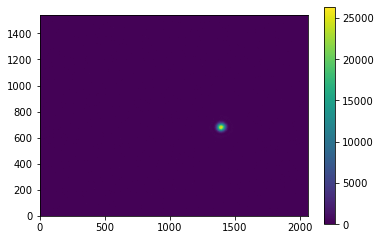

(1542, 2056)


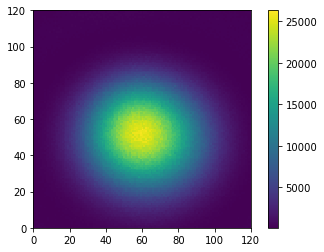

(1542, 2056)


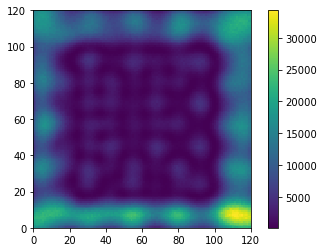

In [43]:
"""
Initial frame check
"""
##import sample image frame

img_idx = 0  #21:'NI', 24:'SI'
img = np.asarray( Image.open(camera_folder + str(img_idx)+'.png') )
print(np.where(img==np.amax(img)))

plt.pcolormesh(np.flip(img,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()
print(img.shape)

##select and crop frame

img_cut = img[x_min:x_max, y_min:y_max]
img_cut=np.flipud(img_cut)
%matplotlib inline

plt.pcolormesh(np.flip(img_cut,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

## reference object borders

border= np.asarray( Image.open(load_folder +'210_borders20.png') )
print(border.shape)
# y_min2, y_max2 = 600,600+img_size
# x_min2, x_max2 = 600,600+img_size
border_cut = border[x_min:x_max, y_min:y_max].copy()

plt.pcolormesh(np.flip(border_cut,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

(1542, 2056)


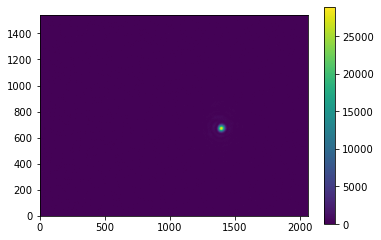

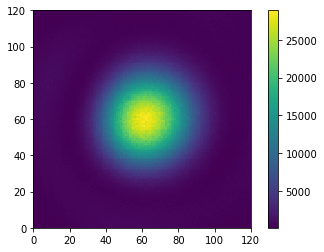

In [45]:
"""
Experimental PSF

exp_psf 
"""
# img_psf = np.asarray( Image.open(PSF_folder + 'square_20x20_psf.bmp') )
img_psf = np.asarray( Image.open(PSF_folder + 'point_source_centre960_20x20.png') )
print(img_psf.shape)
# img_psf=img_psf/np.sum(img_psf)

plt.pcolormesh(np.flip(img_psf,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

exp_psf = img_psf[x_min:x_max, y_min:y_max].copy()
plt.pcolormesh(np.flip(exp_psf,1))
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()
plt.show()

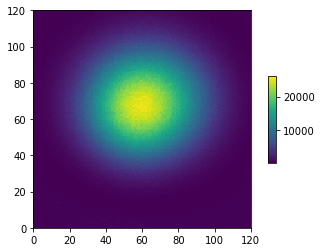

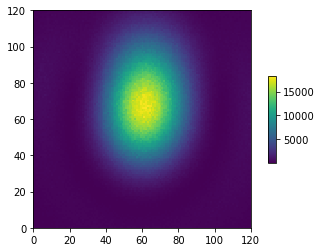

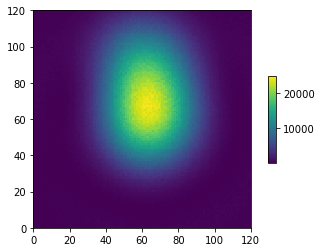

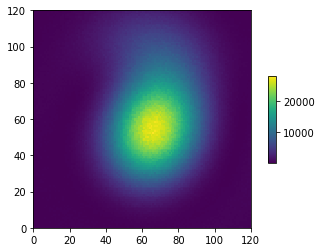

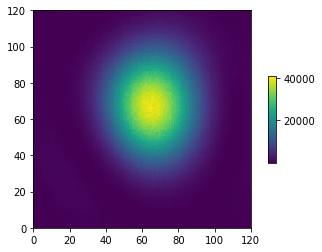

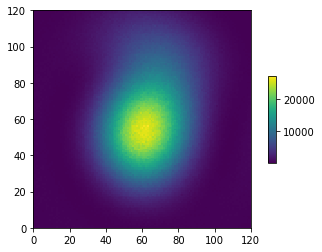

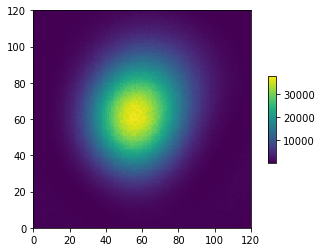

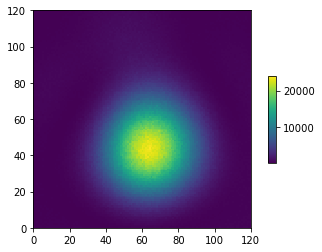

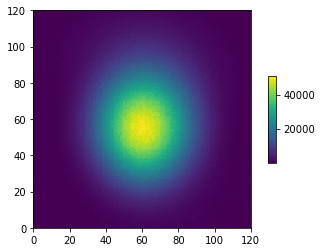

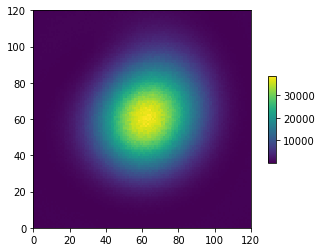

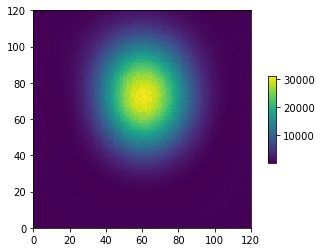

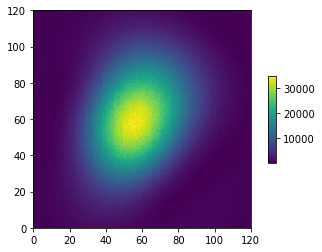

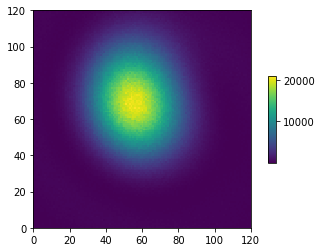

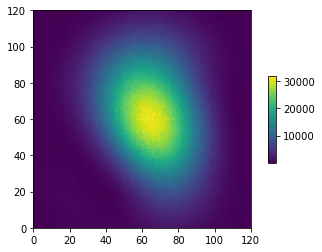

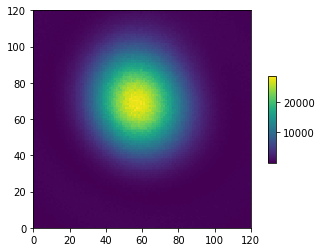

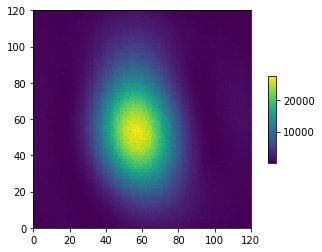

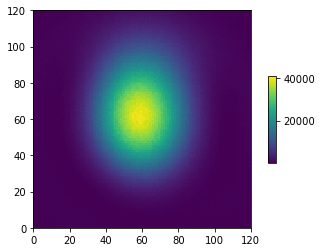

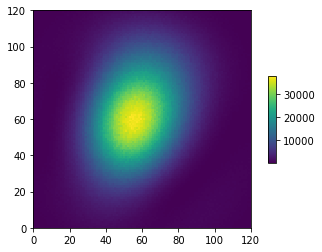

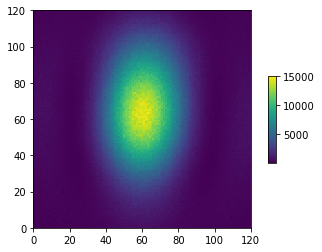

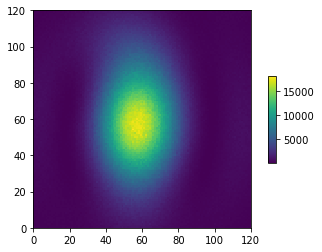

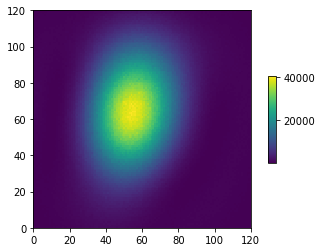

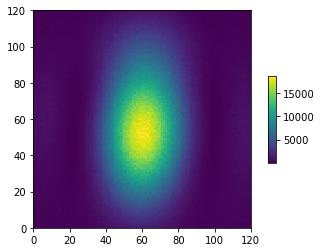

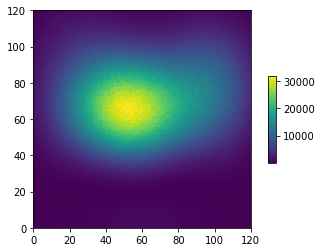

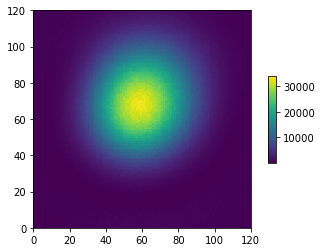

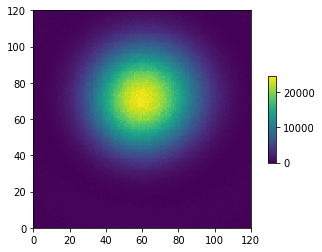

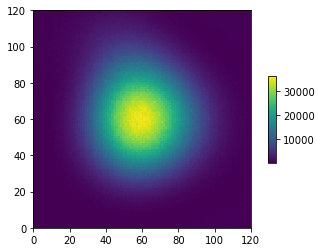

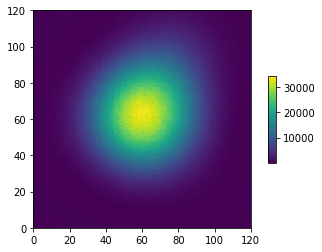

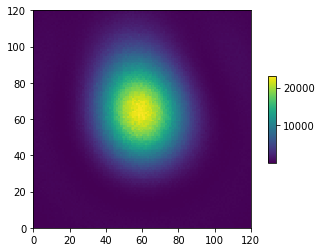

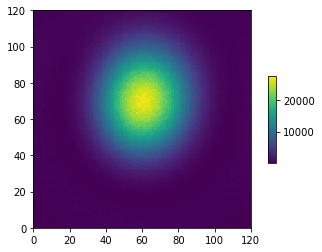

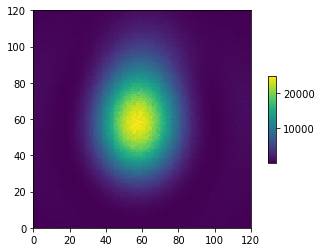

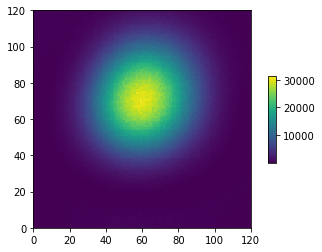

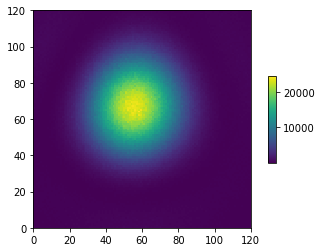

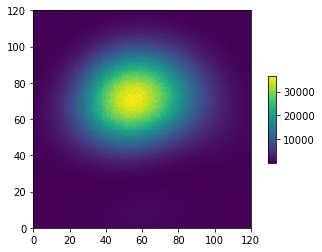

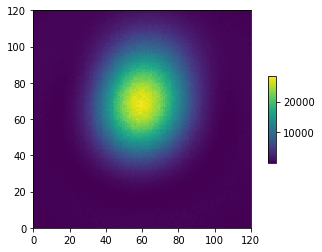

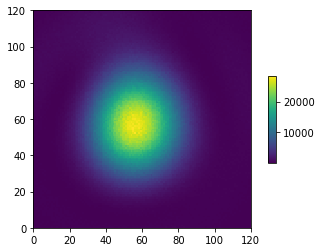

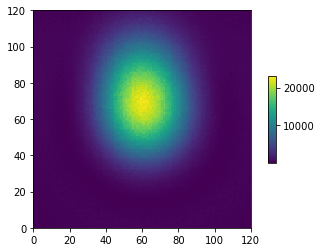

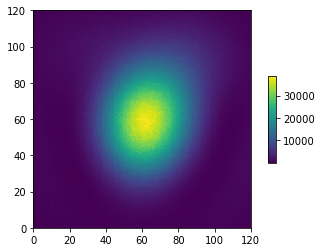

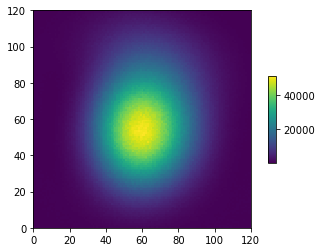

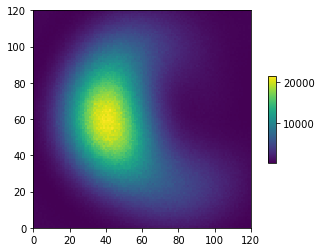

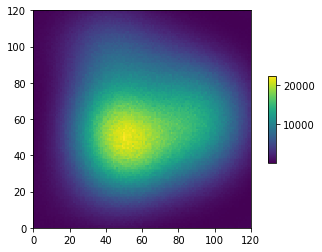

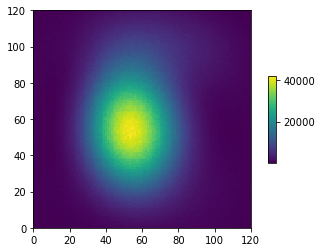

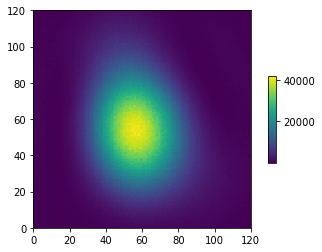

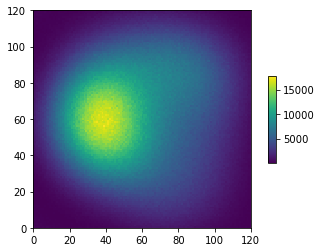

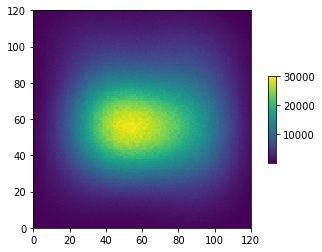

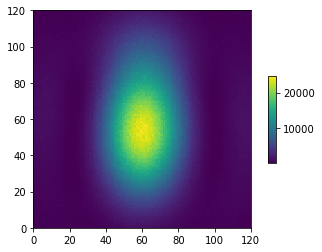

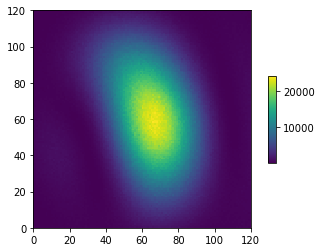

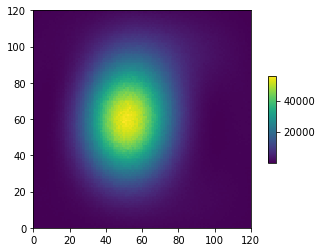

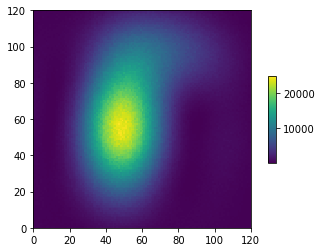

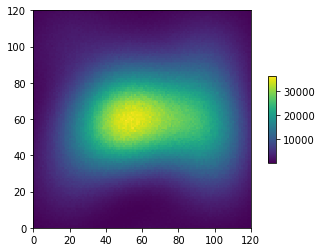

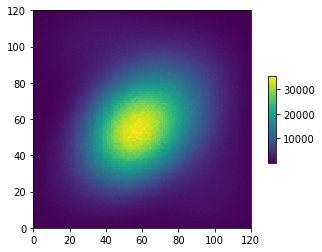

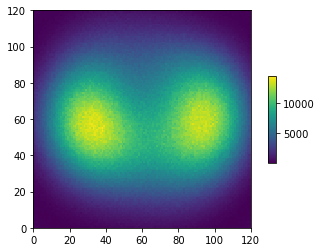

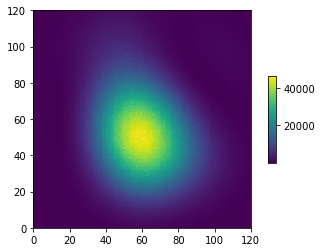

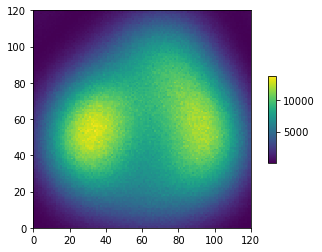

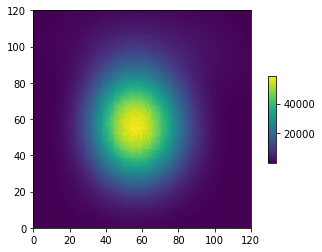

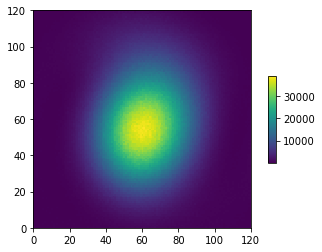

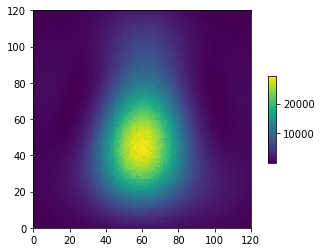

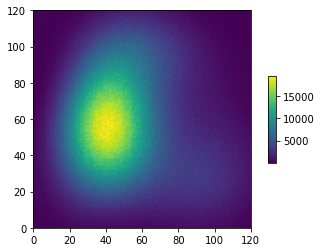

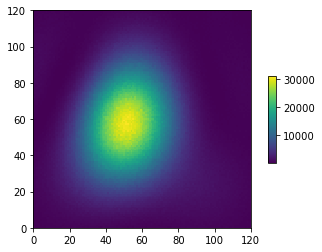

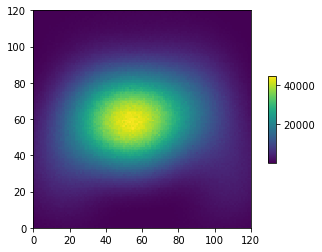

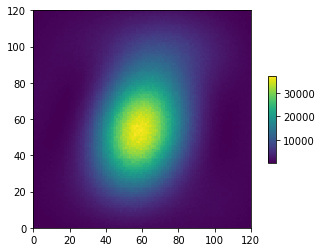

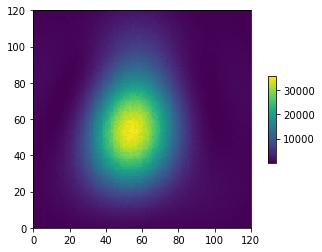

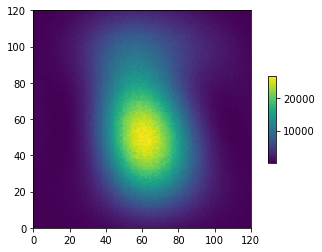

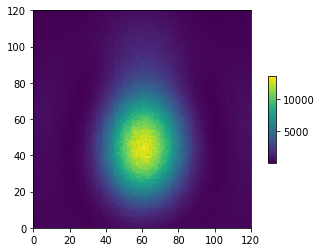

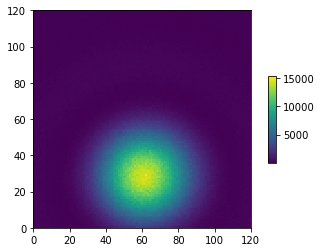

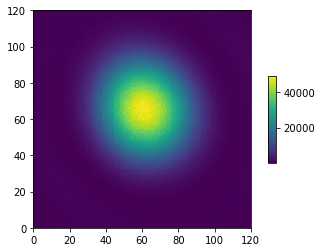

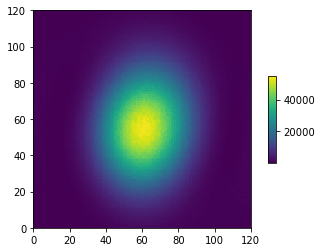

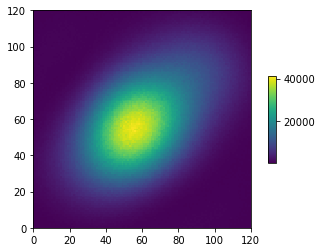

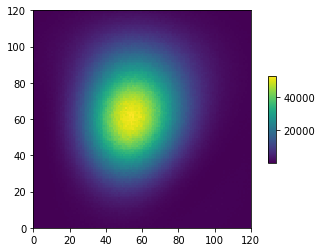

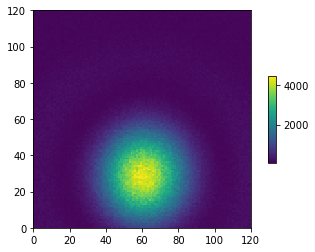

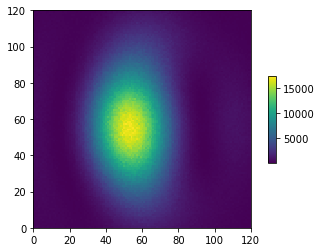

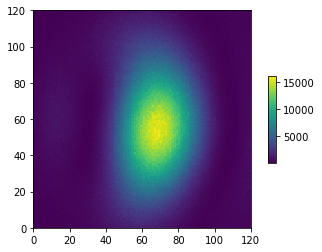

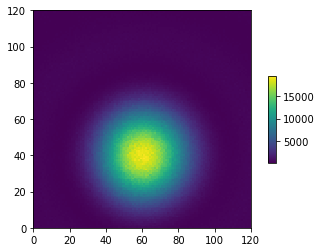

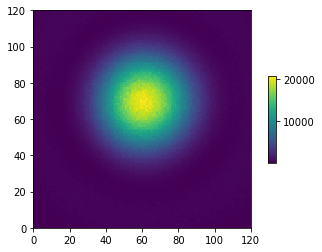

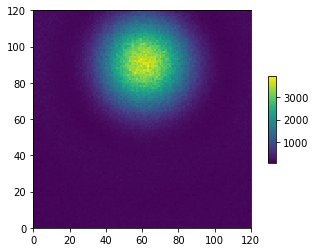

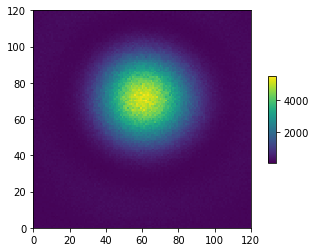

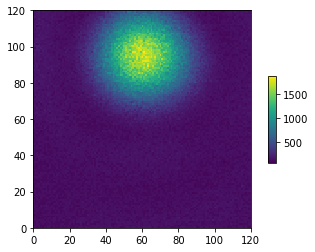

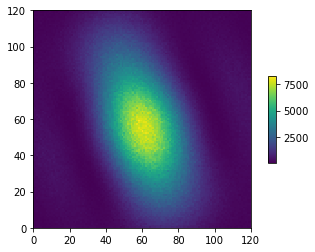

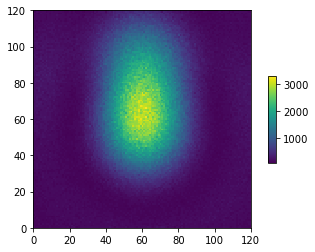

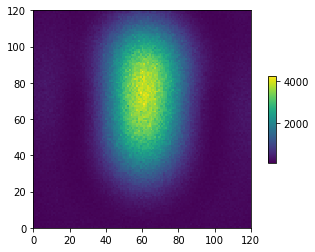

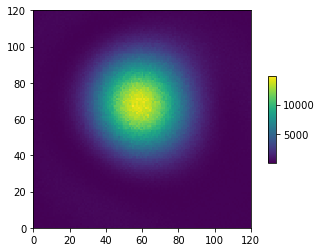

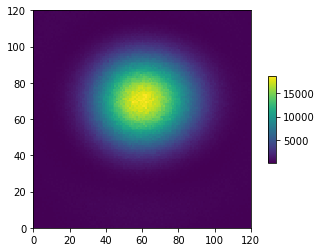

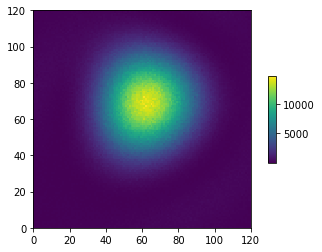

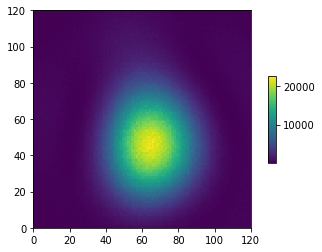

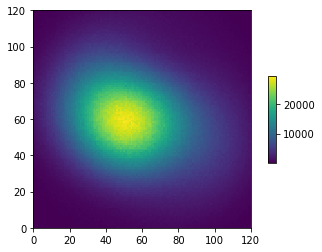

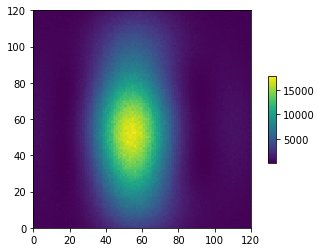

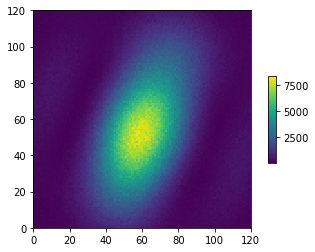

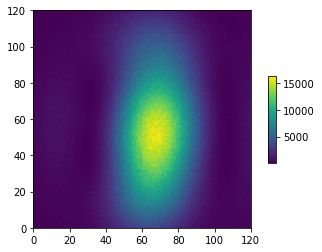

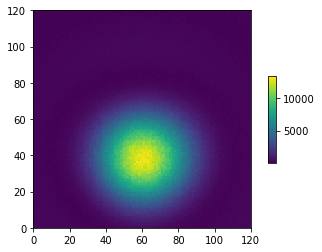

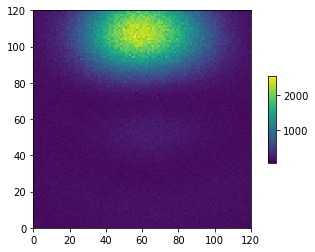

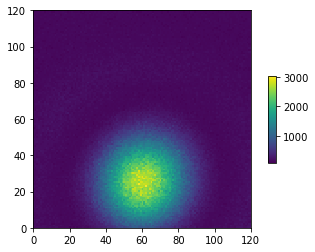

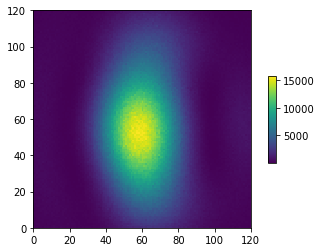

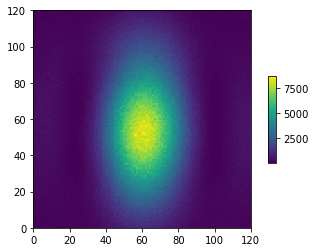

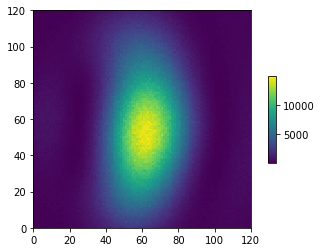

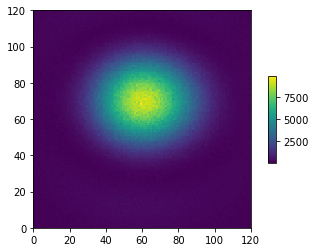

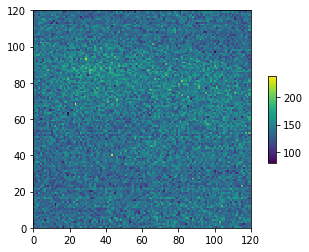

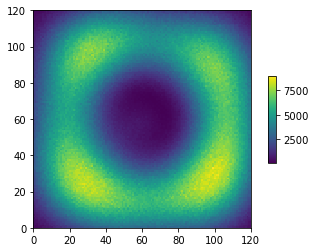

In [46]:
"""
experimental camera direct images of collection of objects (Alphabets and symbols, pairs of lines, university of oxford logos)

logo 
"""
count=0

for i in range(0,8):
    for j in range(0,12):
        img = np.asarray( Image.open(camera_folder + str(count)+'.png') )
        logo[i, j, :, :] = np.flip( img[x_min:x_max, y_min:y_max], 1)
        count+=1
        plt.pcolormesh(logo[i, j, :, :])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.colorbar(shrink=0.4, aspect=10)
        plt.show()

## normalize if needed

# logo=logo/np.max(logo)

In [47]:
"""
saving torch tensors 
"""
# logo_torch=torch.from_numpy(logo)
# torch.save(logo_torch, torch_folder+'alphabet.pt')

'\nsaving torch tensors \n'

In [48]:
### Test logo image

# plt.pcolormesh(logo[0, 0, :, :])
# plt.gca().set_aspect('equal', adjustable='box')
# plt.colorbar(shrink=0.4, aspect=10)
# plt.show()

In [49]:
"""
flip and concatanate all individual frames to a complete image
"""

# logo_flipped = np.flip(logo, 2)
# logo_complete = concate_pad_images(logo_flipped, 20)
# logo_complete=logo_complete/np.max(logo_complete)
# fig=plt.figure()
# plt.pcolormesh(logo_complete)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.colorbar(shrink=0.4, aspect=10)
# # plt.clim(0,255)
# now = datetime.now()
# date_time = now.strftime("camera_%m_%d_%Y__%H_%M_%S")
# plt.savefig(save_folder+date_time+'.png',dpi=150)

'\nflip and concatanate all individual frames to a complete image\n'

# Experimental Deconvolution

In [ ]:
"""
Experimental deconvolution by richardson lucy algorithm run for a given iterations block by block for an image 
"""
#### Decide PSF

# PSF=exp_psf.copy()
PSF=airy_psf(img_size,45)


#### Deconvolve frame by frame for given iterations and PSF
i,j=0,0

for idx,val in enumerate(seq):
    
#     i=int(idx/10)
#     j=idx%10
    i=int(idx/12)
    j=idx%12
    print(i,',',j)
    
    star_conv=logo[i,j].copy() 
    
#     deconvolved_RL,psf_RL = blind_deconv_rl(star_conv, PSF, m_iterations=50,n_iterations=50)
    deconvolved_RL= deconv_rl(star_conv,star_conv,PSF, iterations=500)
#     deconvolved_RL = restoration.richardson_lucy(star_conv, PSF, iterations=100)

    plt.pcolormesh(np.real(star_conv),cmap='gist_stern')#np.abs(star_deconv)**2
    plt.colorbar()
    plt.show()

    plt.pcolormesh(np.real(deconvolved_RL),cmap='gist_stern')#np.abs(star_deconv)**2
    plt.colorbar()
    plt.show()
    
#     plt.pcolormesh(np.real(psf_RL))#np.abs(star_deconv)**2
#     plt.colorbar()
#     plt.show()
    logo_RL[i,j]=deconvolved_RL.copy()  ### resultant deconvoluted frames

In [ ]:
"""
save results of deconvolution as a complete image
"""
### complete image from frames

logo_flipped = np.flip(logo_RL, 2)
logo_complete = concate_pad_images(logo_flipped, 0)
logo_complete=logo_complete/np.max(logo_complete)  

fig=plt.figure()
plt.pcolormesh(logo_complete,cmap='gist_stern') #gist_stern #tab20b #nipy_spectral
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(shrink=0.4, aspect=10)
# plt.clim(0,1)

### save
now = datetime.now()
date_time = now.strftime("Deconvolved_RL_%m_%d_%Y__%H_%M_%S")
plt.savefig(save_folder+date_time+'.png',dpi=150)

In [ ]:
"""
deconvolving complete image
"""
###load image

img_np=np.loadtxt(camera_folder+'logo_10x10_fixed.txt')

# plt.pcolormesh(img_np2)
# plt.gca().set_aspect('equal', adjustable='box')
# plt.colorbar(shrink=0.4, aspect=10)
# plt.show()

print(img_np.shape)

###increase edge padding to allow better deconvolution

xx,yy=img_np.shape[1],img_np.shape[0]
xm,ym=(int(xx/100)+2)*100,(int(yy/100)+2)*100
img_np3=np.zeros((ym,xm),np.complex128)
img_np3[int((ym-yy)/2):int((ym-yy)/2)+yy,int((xm-xx)/2):int((xm-xx)/2)+xx]=img_np2
# plt.pcolormesh(np.abs(img_np3))
# plt.gca().set_aspect('equal', adjustable='box')
# plt.colorbar(shrink=0.4, aspect=10)
# plt.show()

###deconvolution

PSF=PSF=airy_psf(100,45)
deconvolved_RL=np.zeros((ym,xm),np.complex128)
# print(deconvolved_RL.shape)


deconvolved_RL= deconv_rl(img_np3,img_np3,PSF, iterations=100)

###show and save final results

deconvolved_RL=np.abs(deconvolved_RL)
deconvolved_RL=deconvolved_RL/np.max(deconvolved_RL)

fig=plt.figure()
plt.pcolormesh(np.abs(deconvolved_RL))#,cmap='gist_stern'
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(shrink=0.4, aspect=10)
plt.clim(0,1)
now = datetime.now()
date_time = now.strftime("Deconvolved_RL_%m_%d_%Y__%H_%M_%S_"+str(count))
plt.savefig(save_folder+date_time+'.png',dpi=150)
plt.show()

# Simulation University of Oxford Logo

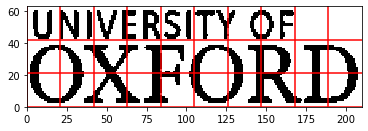

logo size: (63, 210) pixels
divided into: 3x10=30
each image size : (21, 21)


In [14]:
"""
Import University of Oxford logo and divide that into 3x10 blocks
"""

img_file = r'D:\Projects Data\2D_HGM_data\sources\oxford_logo3.png'

im = Image.open(img_file).convert('L')
im_flipped = ImageOps.mirror(im.rotate(180))
im_flipped = ImageOps.invert(im_flipped)

threshold = 50
bw = im_flipped.point(lambda x: 0 if x<threshold else 255, '1')

logo = np.asarray(bw) #/ np.max(logo)

plt.pcolormesh(logo, cmap='Greys')
plt.gca().set_aspect('equal', adjustable='box')
for i in range(int(logo.shape[0] / DMD_basis)):
    plt.axhline(y=i*DMD_basis, color='red')
for j in range(int(logo.shape[1] / DMD_basis)):
    plt.axvline(x=j*DMD_basis, color='red')
plt.savefig("DMD.png")
plt.show()

print('logo size: '+str(logo.shape)+ ' pixels')

x_imgs, y_imgs = logo.shape[0] / DMD_basis, logo.shape[1] / DMD_basis
print('divided into: '+ str(int(x_imgs)) +'x' +str(int(y_imgs))+'='+str(int(x_imgs*y_imgs)))

m, n = 2,3

logo_square = logo[m*DMD_basis:(m+1)*DMD_basis,n*DMD_basis:(n+1)*DMD_basis]/ np.max(logo)
print('each image size :', logo_square.shape)

#plt.pcolormesh(logo_square, cmap='Greys');
#plt.gca().set_aspect('equal', adjustable='box');
#plt.show()

source_210 = np.zeros((210,210))
for i in range(np.shape(logo_square)[0]):
    for j in range(np.shape(logo_square)[1]):
        source_210[i*10:(i+1)*10,j*10:(j+1)*10] = logo_square[i,j]

#source_84 = interp_near_pixels(logo_square, 4)
#source_84 = np.zeros((21*4,21*4))
#for i in range(np.shape(logo_square)[0]):
#    for j in range(np.shape(logo_square)[1]):
#        source_84[i*4:(i+1)*4,j*4:(j+1)*4] = logo_square[i,j]
        
#plt.pcolormesh(source_84, cmap='Greys');
#plt.gca().set_aspect('equal', adjustable='box');

In [18]:
"""
Calculate images based on gaussian psf with size 250
"""
x_imgs, y_imgs = int(logo.shape[0] / DMD_basis), int(logo.shape[1] / DMD_basis)

# sources = np.zeros( (x_imgs, y_imgs, DMD_basis*up_scale, DMD_basis*up_scale) )
sources_pad = np.zeros( (x_imgs, y_imgs, x.shape[0],  x.shape[0]) )
PSF= gaussian_psf(250,sigma)
images = np.copy(sources_pad)*0
HG_microscopy_images = np.copy(sources_pad)*0
images_deconv = np.copy(sources_pad)*0
E_HG = np.copy(sources_pad)*0
beta = np.zeros( (x_imgs, y_imgs, HG_basis, HG_basis) )
J_mn = np.zeros( (x_imgs, y_imgs, HG_basis, HG_basis) )

# quick test for a single square:
#x_imgs = 2
#y_imgs = 1
for m in range(x_imgs):
    for n in range(y_imgs):
        logo_square = logo[m*DMD_basis:(m+1)*DMD_basis,n*DMD_basis:(n+1)*DMD_basis]
        
        sources_pad[m,n,:,:], padding = img21x21_to_sim_size(logo_square, x, up_scale)


#         sources[m,n,:,:] = interp_near_pixels(logo_square, up_scale)
#         sources_pad[m,n,:,:] = np.pad(sources[m,n,:,:], (int(padding/2), int(padding/2)) , mode='constant', constant_values=0)
        
        # camera
        images[m,n,:,:] = propagate(sources_pad[m,n,:,:], PSF)
        # HG microscopy
        E_HG[m,n,:,:], beta[m,n,:,:], J_mn[m,n,:,:]  = HG_microscopy2d(images[m,n,:,:])
        
        print('calculated image: ' + str(m) + ',' + str(n))

calculated image: 0,0
calculated image: 0,1
calculated image: 0,2
calculated image: 0,3
calculated image: 0,4
calculated image: 0,5
calculated image: 0,6
calculated image: 0,7
calculated image: 0,8
calculated image: 0,9
calculated image: 1,0
calculated image: 1,1
calculated image: 1,2
calculated image: 1,3
calculated image: 1,4
calculated image: 1,5
calculated image: 1,6
calculated image: 1,7
calculated image: 1,8
calculated image: 1,9
calculated image: 2,0
calculated image: 2,1
calculated image: 2,2
calculated image: 2,3
calculated image: 2,4
calculated image: 2,5
calculated image: 2,6
calculated image: 2,7
calculated image: 2,8
calculated image: 2,9


(100, 100)


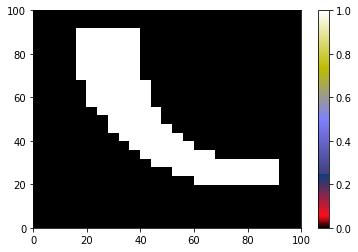

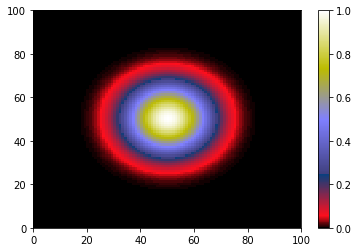

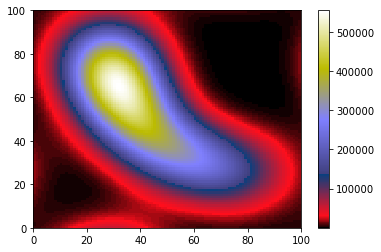

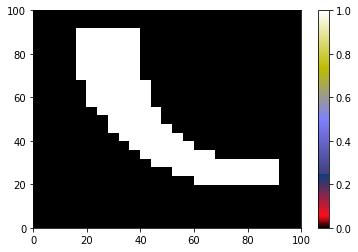

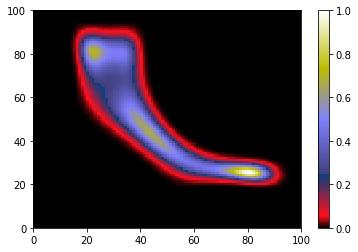

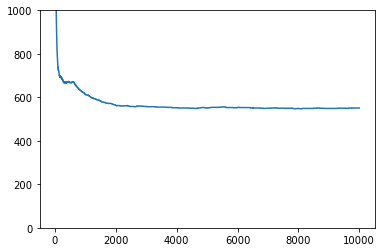

In [23]:
"""
simulate university of oxford logo with airy psf of size 100 and then deconvolve it using richardson lucy algorithm or fft deconvolution
and maybe calculate MSE loss for reference.
"""
# PSF=PSF/np.sqrt(np.sum(np.abs(PSF)**2 +1e-10))
# star_conv = convolve(sources_pad[m,n,:,:], PSF)
# star_conv = star_conv / np.sqrt(np.sum(np.abs(star_conv)**2) +1e-10)
# star_deconv = deconvolve(star_conv, PSF)
# star_deconv = star_deconv / np.sqrt(np.sum(np.abs(star_deconv)**2) +1e-10)
m,n=0,0
# star=np.real(sources_pad[m,n,51:201,51:201])
star=np.real(sources_pad[m,n,75:175,75:175]).copy()
psf=airy_psf(100,43)
print(star.shape)
star_conv = convolve(star, psf)
# star_conv = star_conv / np.sqrt(np.sum(np.abs(star_conv)**2) +1e-10)
# deconvolved_sim_RL = restoration.richardson_lucy(star_conv, psf, iterations=1000)
# deconvolved_sim_RL,psf_sim_RL = blind_deconv_rl(star_conv, psf, m_iterations=50,n_iterations=50)
# deconvolved_sim_RL,mse=deconv_rl(star_conv,np.ones((100,100)), psf, iterations=10000)
deconvolved_sim_RL,mse,tempy=ref_deconv_rl(star_conv,np.ones((100,100)),star, psf, iterations=10000)
deconvolved_sim_RL=deconvolved_sim_RL/np.max(deconvolved_sim_RL)
star_deconv = deconvolve(star_conv, psf)
# f, axes = plt.subplots(2,2)
# axes[0,0].imshow(sources_pad[m,n,:,:])
# axes[0,1].imshow(PSF)
# axes[1,0].imshow(np.real(star_conv))
# axes[1,1].imshow(np.real(star_deconv))
# plt.show()
plt.pcolormesh(np.abs(star)**2,cmap='gist_stern')
plt.colorbar()
plt.show()
# plt.pcolormesh(np.abs(sources_pad[m,n,:,:])**2)
# plt.colorbar()
# plt.show()
plt.pcolormesh(np.abs(psf)**2,cmap='gist_stern')
plt.colorbar()
plt.show()
plt.pcolormesh(np.abs(star_conv)**2,cmap='gist_stern')
plt.colorbar()
plt.show()
plt.pcolormesh(np.abs(star_deconv)**2,cmap='gist_stern')
plt.colorbar()
plt.show()
plt.pcolormesh(np.abs(deconvolved_sim_RL)**2,cmap='gist_stern')
plt.colorbar()
plt.show()
# plt.pcolormesh(np.abs(tempy)**2,cmap='gist_stern')
# plt.colorbar()
# plt.show()
plt.plot(np.abs(mse))
plt.ylim(0,1000)
plt.show()

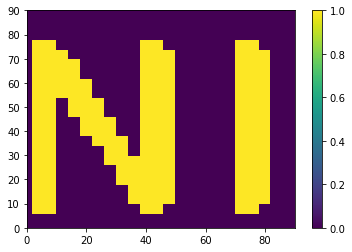

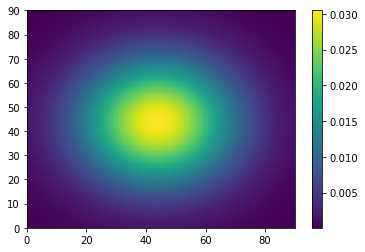

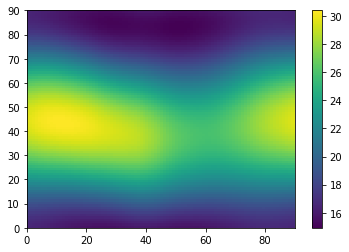

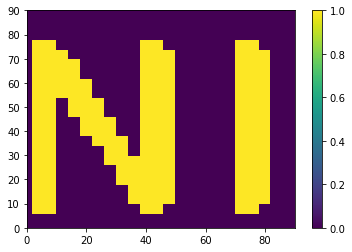

In [37]:
"""
simulate university of oxford logo with gaussian psf of size 90 and then deconvolve it using richardson lucy algorithm or fft deconvolution
and maybe calculate MSE loss for reference. (centre of psf array shift to 126 instead of 125 in (250,250))
"""
arr_size=90
m,n=2,1
centre=126 ## normally 125 everywhere else
PSF=gaussian_psf(arr_size,sigma,centre)
star_conv = convolve(sources_pad[m,n,centre-int(arr_size/2):centre+int(arr_size/2),centre-int(arr_size/2):centre+int(arr_size/2)], PSF)

# star_conv = star_conv / np.sqrt(np.sum(np.abs(star_conv)**2) +1e-10)
star_deconv = deconvolve(star_conv, PSF)
# star_deconv = star_deconv / np.sqrt(np.sum(np.abs(star_deconv)**2) +1e-10)
star_deconv = star_deconv / np.max(star_deconv)
plt.pcolormesh(np.real(sources_pad[m,n,81:171,81:171]))#np.abs(sources_pad[m,n,:,:])**2
plt.colorbar()
plt.show()
plt.pcolormesh(np.real(PSF))#np.abs(PSF)**2
plt.colorbar()
plt.show()
plt.pcolormesh(np.real(star_conv))#np.abs(star_conv)**2
plt.colorbar()
plt.show()
plt.pcolormesh(np.real(star_deconv))#np.abs(star_deconv)**2
plt.colorbar()
plt.show()